In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r drive/MyDrive/IFT780/TP2/prog/* .

# Réseaux à convolution

Dans ce notebook, nous crérons un réseau à convolution.  Mais avant de commencer, assurez-vous d'avoir bien compris les notebooks sur la **convolution**, la **batch-norm** et le **dropout**.

Ici, nous utiliserons pour l'essentiel le code dans les fichiers suivants :

    model/Model.py
    layers/Conv.py 
    utils/model_loss.py
    layers/MaxPool.py
    
Comme au tp1, la classe **Model** "crée" un réseau de neurones en ajoutant successivement des couches et une fonction de perte.


In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def create_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, channels, input_size, input_size)
    y = np.array([0, 1, 2, 1, 2])
    return X, y


In [4]:
%cd utils/cython/
!./build_cython.sh
%cd ../../

C:\Users\Alexandre\Documents\UdeS\IFT780\TP\tp2\utils\cython
C:\Users\Alexandre\Documents\UdeS\IFT780\TP\tp2


'.' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


## Modèle simple

Commençons avec un modèle très simple à une couche cachée.  Pour la fonction:

    cross_entropy_loss
    
vous pouvez récupérer votre code du tp1


In [5]:
from model.Model import Model
from layers.Conv import Conv2DNaive
from utils.model_loss import cross_entropy_loss

num_filters = 3
filter_size = 4
channels = 1
num_inputs = 5
input_size = 4
padding = 0
stride = 1

np.random.seed(0)
model = Model()
layer = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                        stride=stride, padding=padding, weight_scale=1e-1)
model.add(layer)
model.add_loss(cross_entropy_loss)

In [6]:
##############################################################################
# TODO: Récupérez le code "naïf" de la convolution que vous avez fait dans   #
#   le notebook sur la convolution et le mettre dans la fonction "forward"   #
#   de la classe Conv2DNaive dans le fichier Conv.py.                        #
#   S'il n'y a pas de bug, le test suivant devrait passer                    #
##############################################################################
X, y = create_toy_data()
scores = model.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.1734064542821017e-08


In [7]:
loss, dScores, _ = model.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur  inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.478083827448259
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.881784197001252e-15


In [8]:
##############################################################################
# TODO: Implémenter la méthode backward (rétro-propagation) de la classe de  #
# couche Conv2DNaive.                                                        #
##############################################################################

_ = model.backward(dScores.reshape(5, 3, 1, 1))

In [9]:
from utils.gradients import evaluate_numerical_gradient

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
def rel_error(x, y):
    rel = np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))
    return np.max(rel)

gradients = model.gradients()
model_params = model.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.504079e-10
L0-b max relative error: 8.742832e-11


# Test de différentes implantations de la convolution

    version naive
    version "matricée"
    version "optimisée"

La version optimisée implique l'utilisation de code **"cython"**


In [10]:
from model.Model import Model
from layers.Conv import Conv2DNaive, Conv2DMat, Conv2DCython
from utils.model_loss import cross_entropy_loss

num_filters = 3
filter_size = 4
channels = 1

num_inputs = 5
input_size = 4
padding = 0
stride = 1

def create_toy_model():
    np.random.seed(0)
    model = Model()
    layer = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                        stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_mat():
    np.random.seed(0)
    model = Model()
    layer = Conv2DMat(num_filters, filter_size=filter_size, channels=channels, 
                      stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_fast():
    np.random.seed(0)
    model = Model()
    layer = Conv2DCython(num_filters, filter_size=filter_size, channels=channels, 
                         stride=stride, padding=padding, weight_scale=1e-1)
    model.add(layer)
    model.add_loss(cross_entropy_loss)
    return model

model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()
X, y = create_toy_data()

<font size="4">CNN avec matricisation des entrées</font>

Ici le code "forward" et "backward" de la convolution "matricée" vous est fourni.  En principe, tout devrait fonctionner.

In [11]:
scores = model_mat.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.1734066208155554e-08


In [12]:
loss, dScores_mat, _ = model_mat.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur  inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.478083827448259
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.881784197001252e-15


In [13]:
##############################################################################
# Normalement cette ligne devrait fonctionner car le code est donnée         #
##############################################################################

_ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))

In [14]:
gradients = model_mat.gradients()
model_params = model_mat.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_mat, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.504074e-10
L0-b max relative error: 8.742806e-11


<font size="4">CNN vectorisé, utilise cython</font>

Ici le code "forward" et "backward" de la convolution "cythonisée" vous est fourni.

In [15]:
##############################################################################
# Normalement ces lignes devraient fonctionner car le code est donnée        #
##############################################################################

scores = model_fast.forward(X).reshape(num_inputs, num_filters)
correct_scores = np.asarray([[2.26107191, 1.90356006, -10.7996371 ],
                             [-4.03277981, 6.72254124, 0.36232013],
                             [-0.33115169, 3.30740614, 8.24078811],
                             [-0.78558615, 3.5691293, -5.41204248],
                             [7.16759091, -7.01187203, -4.51633761]])

print('Your scores:')
print(scores)
print()
print('correct scores:')
print(correct_scores)
print()

# La différence devrait être assez basse, en principe inférieure à 1e-7.
print('Difference between your scores and correct scores: ', np.sum(np.abs(scores - correct_scores)))

Your scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

correct scores:
[[  2.26107191   1.90356006 -10.7996371 ]
 [ -4.03277981   6.72254124   0.36232013]
 [ -0.33115169   3.30740614   8.24078811]
 [ -0.78558615   3.5691293   -5.41204248]
 [  7.16759091  -7.01187203  -4.51633761]]

Difference between your scores and correct scores:  3.173406432077641e-08


In [16]:
loss, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)
correct_loss = 2.47808382744825

# on devrait obtenir une erreur  inférieure à environ 1e-12.
print('Loss: ', loss)
print('Correct loss: ', correct_loss)
print('Difference between your loss and correct loss: ', np.sum(np.abs(loss - correct_loss)))

Loss:  2.4780838274482586
Correct loss:  2.47808382744825
Difference between your loss and correct loss:  8.43769498715119e-15


In [17]:
##############################################################################
# Normalement cette ligne devrait fonctionner car le code est donnée         #
##############################################################################

_ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

In [18]:
gradients = model_fast.gradients()
model_params = model_fast.parameters()

# L'erreur devrait être inférieure à 1e-5
for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_fast, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 9.383004e-10
L0-b max relative error: 8.742806e-11


<font size="4">Comparaison des performances</font>

Maintenant, voyons à quel point le type d'implantation d'une convolution peut avoir un impact sur la rapidité d'exécution.

<font size="3">Forward</font>

In [19]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [20]:
print("version naive...")
%timeit model_naive.forward(X)
print("version matricée...")
%timeit model_mat.forward(X)
print("version rapide cythonisée...")
%timeit model_fast.forward(X)

version naive...
136 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
version matricée...
34.3 µs ± 1.76 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
version rapide cythonisée...
26.3 µs ± 704 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<font size="3">Rétro-propagation</font>

In [21]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [22]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_filters)
loss_naive, dScores_naive, _ = model_naive.calculate_loss(scores, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_filters)
loss_mat, dScores_mat, _ = model_fast.calculate_loss(scores, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_filters)
loss_fast, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)

In [23]:
# En principe, les loss et des gradients devraient être les mêmes

if np.abs(loss_naive - loss_mat) + \
    np.abs(loss_naive - loss_fast) + \
    np.abs(loss_mat - loss_fast) > 1e-6:
    print("Erreur!")
else:
    print("Loss bonne!")    

if (np.abs(dScores_mat - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_fast - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_mat - dScores_fast)).flatten().mean() > 1e-6 :
    print("Erreur!")
else:
    print("Gradients bons!")    


Loss bonne!
Gradients bons!


In [24]:
print("version naive...")
%timeit _ = model.backward(dScores_naive.reshape(5, 3, 1, 1))
print("version matricée...")
%timeit _ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
print("version rapide cythonisée...")
%timeit _ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

version naive...
121 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
version matricée...
27.8 µs ± 398 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
version rapide cythonisée...
8.88 µs ± 298 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


<font size="5">CNN à 2 couches</font>

Ici nous testerons des réseaux à 2 couches convolutives.  En principe, si le code des dernières cellules fonctionne, le code des prochaines cellules devrait fonctionner!


In [25]:
from model.Model import Model
from layers.Conv import Conv2DNaive, Conv2DMat, Conv2DCython
from utils.model_loss import cross_entropy_loss

num_filters = 4
filter_size = 3
channels = 2

num_inputs = 5
input_size = 5
padding = 1
stride = 2

num_classes = 3

def create_toy_model():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DNaive(num_filters, filter_size=filter_size, channels=channels, 
                         stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DNaive(num_classes, filter_size=3, channels=num_filters, 
                         weight_scale=1e-1)
    
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_mat():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DMat(num_filters, filter_size=filter_size, channels=channels, 
                       stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DMat(num_classes, filter_size=3, channels=num_filters, 
                       weight_scale=1e-1)
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_model_fast():
    np.random.seed(0)
    model = Model()
    layer0 = Conv2DCython(num_filters, filter_size=filter_size, channels=channels, 
                          stride=stride, padding=padding, weight_scale=1e-1)
    layer1 = Conv2DCython(num_classes, filter_size=3, channels=num_filters, 
                          weight_scale=1e-1)
    model.add(layer0)
    model.add(layer1)
    model.add_loss(cross_entropy_loss)
    return model

def create_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, channels, input_size, input_size)
    y = np.array([0, 1, 2, 1, 2])
    return X, y

model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()
X, y = create_toy_data()

In [26]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_classes)
loss_naive, dScores_naive, _ = model_naive.calculate_loss(scores_naive, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_classes)
loss_mat, dScores_mat, _ = model_mat.calculate_loss(scores_mat, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_classes)
loss_fast, dScores_fast, _ = model_fast.calculate_loss(scores_fast, y, 0.1)

In [27]:
# En principe, les loss et des gradients devraient être les mêmes

if np.abs(loss_naive - loss_mat) + \
    np.abs(loss_naive - loss_fast) + \
    np.abs(loss_mat - loss_fast) > 1e-6:
    print("Erreur!")
else:
    print("Loss bonne!")    

if (np.abs(dScores_mat - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_fast - dScores_naive)).flatten().mean() + \
    (np.abs(dScores_mat - dScores_fast)).flatten().mean() > 1e-6 :
    print("Erreur!")
else:
    print("Gradients bons!")    


Loss bonne!
Gradients bons!


In [28]:
_ = model_naive.backward(dScores_naive.reshape(5, 3, 1, 1))
_ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
_ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

In [29]:
# Vérification du gradient pour le modèle naif, devrait être inférieur à 1e-4
gradients = model_naive.gradients()
model_params = model_naive.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_naive, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629576e-09
L0-b max relative error: 5.164367e-10
L1-W max relative error: 1.315612e-09
L1-b max relative error: 2.627920e-09


In [30]:
# Gradient check pour le modèle matricisé, devrait être inférieur à 1e-4
gradients = model_mat.gradients()
model_params = model_mat.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_mat, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629620e-09
L0-b max relative error: 5.164374e-10
L1-W max relative error: 7.471280e-10
L1-b max relative error: 2.627933e-09


In [31]:
# Gradient check pour le modèle cythonisé.
# Les valeurs peuvent être légèrement différentes de celles
# obtenues pour model_naive et model_mat (Effet de bord de Cython).
# En autant qu'elles restent inférieures à 1e-4, c'est correct.
gradients = model_fast.gradients()
model_params = model_fast.parameters()

for layer_name, layer_params in model_params.items():
    for param_name, _ in layer_params.items():
        grad_num = evaluate_numerical_gradient(X, y, model_fast, layer_name, param_name, reg=0.1)
        max_error = rel_error(grad_num, gradients[layer_name][param_name])
        
        print('%s max relative error: %e' % (layer_name + '-' + param_name, max_error))

L0-W max relative error: 2.629601e-09
L0-b max relative error: 4.003972e-10
L1-W max relative error: 1.746894e-09
L1-b max relative error: 2.627867e-09


<font size="4">Comparaison des performances</font>

<font size="3">Propagation avant</font>

les différentes implantation de convolution devraient entraîner divers temps d'exécution.

In [32]:
model_naive = create_toy_model()
model_mat = create_toy_model_mat()
model_fast = create_toy_model_fast()

In [33]:
print("CNN 2 couches, conv naive")
%timeit model_naive.forward(X)
print("CNN 2 couches, conv mat")
%timeit model_mat.forward(X)
print("CNN 2 couches, conv fast")
%timeit model_fast.forward(X)

CNN 2 couches, conv naive
1.54 ms ± 39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
CNN 2 couches, conv mat
109 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CNN 2 couches, conv fast
56.2 µs ± 2.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<font size="3">Rétro-propagation</font>

In [34]:
scores_naive = model_naive.forward(X).reshape(num_inputs, num_classes)
_, dScores_naive, _ = model_naive.calculate_loss(scores_naive, y, 0.1)

scores_mat = model_mat.forward(X).reshape(num_inputs, num_classes)
_, dScores_mat, _ = model_fast.calculate_loss(scores, y, 0.1)

scores_fast = model_fast.forward(X).reshape(num_inputs, num_classes)
_, dScores_fast, _ = model_fast.calculate_loss(scores, y, 0.1)

In [35]:
print("CNN 2 couches, gradient conv naive")
%timeit _ = model_naive.backward(dScores_naive.reshape(5, 3, 1, 1))
print("CNN 2 couches, gradient conv mat")
%timeit _ = model_mat.backward(dScores_mat.reshape(5, 3, 1, 1))
print("CNN 2 couches, gradient conv fast")
%timeit _ = model_fast.backward(dScores_fast.reshape(5, 3, 1, 1))

CNN 2 couches, gradient conv naive
2.48 ms ± 62.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CNN 2 couches, gradient conv mat
146 µs ± 4.07 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
CNN 2 couches, gradient conv fast
22 µs ± 990 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<font size="5">MaxPool</font>

Intégront maintenant le "Max pooling" à notre arsenal.

<font size="3">Propagation avant</font>

In [36]:
###############################################
# Voir le code de la classe MaxPool2DNaive    #
###############################################
import numpy as np
from layers.MaxPool import MaxPool2DNaive

X_shape = (2, 3, 4, 4)
X = np.linspace(-0.3, 0.4, num=np.prod(X_shape)).reshape(X_shape)

layer = MaxPool2DNaive(pooling_size=(2,2), stride=(2,2))

out = layer.forward(X)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Retourne l'erreur relative maximale des matrices de gradients passées en paramètre.
# Pour chaque paramètre, l'erreur relative devrait être inférieure à environ 1e-8.
print('difference: ', (out - correct_out).flatten().mean())

difference:  1.315789355365212e-10


<font size="3">Rétro-propagation</font>

In [37]:
###############################################
# Voir le code de la classe MaxPool2DNaive    #
###############################################

X = np.random.randn(2, 2, 4, 4)

layer = MaxPool2DNaive(pooling_size=(2,2), stride=(2,2))

out = layer.forward(X)
dX = layer.backward(out)

print("Inputs")
print(X)
# Devrait retouner le max de chaque convolution
print("Outputs")
print(out)
# Devrait replacer les éléments des sorties au même endroit que X
print("Gradients")
print(dX)

Inputs
[[[[-0.35399391 -1.37495129 -0.6436184  -2.22340315]
   [ 0.62523145 -1.60205766 -1.10438334  0.05216508]
   [-0.739563    1.5430146  -1.29285691  0.26705087]
   [-0.03928282 -1.1680935   0.52327666 -0.17154633]]

  [[ 0.77179055  0.82350415  2.16323595  1.33652795]
   [-0.36918184 -0.23937918  1.0996596   0.65526373]
   [ 0.64013153 -1.61695604 -0.02432612 -0.73803091]
   [ 0.2799246  -0.09815039  0.91017891  0.31721822]]]


 [[[ 0.78632796 -0.4664191  -0.94444626 -0.41004969]
   [-0.01702041  0.37915174  2.25930895 -0.04225715]
   [-0.955945   -0.34598178 -0.46359597  0.48148147]
   [-1.54079701  0.06326199  0.15650654  0.23218104]]

  [[-0.59731607 -0.23792173 -1.42406091 -0.49331988]
   [-0.54286148  0.41605005 -1.15618243  0.7811981 ]
   [ 1.49448454 -2.06998503  0.42625873  0.67690804]
   [-0.63743703 -0.39727181 -0.13288058 -0.29779088]]]]
Outputs
[[[[0.62523145 0.05216508]
   [1.5430146  0.52327666]]

  [[0.82350415 2.16323595]
   [0.64013153 0.91017891]]]


 [[[0.786327

<font size="5">ConvNet à N couches</font>

Dans les cellules qui suivent, vous devez compléter la fonction 

    create_Nlayer_cnn(num_filter_layer1, num_filter_layer2, fc_size, weight_scale)
    
avec au moins **3 couches convolutives**, du *max pooling*, du *dropout* des opérations *batchNorm* et atteindre les performances mentionnées plus loins.  Il est **fortement suggéré** d'utiliser le code cythonisé pour les opération de convolution et de max pooling.

In [38]:
from layers.BatchNorm import SpatialBatchNorm
from layers.Conv import Conv2DCython
from layers.Dense import Dense
from layers.Flatten import Flatten
from layers.MaxPool import MaxPool2DCython
from layers.Dropout import Dropout
from model.Model import Model
from utils.model_loss import cross_entropy_loss

# paramètres de convolution, à modifier au besoin
filter_size = 3
channels = 3
stride = 1
p_dropout = 0.4
pad = int((filter_size - 1)/2)

# paramètres dense
num_classes = 10

def create_Nlayer_cnn(init_weight_scale):
    model = Model()
    
    ## TODO AOUTER ICI LE CODE DU CNN DE VOTRE CRU
    # Architecture inspiré de: https://www.youtube.com/watch?v=VQYMOJnN6xg
    layer0 = Conv2DCython(32, 
                          filter_size=filter_size,
                          channels=channels, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer1 = Conv2DCython(32, 
                          filter_size=filter_size,
                          channels=32, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer2 = Conv2DCython(64, 
                          filter_size=filter_size,
                          channels=32, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer3 = Conv2DCython(64, 
                          filter_size=filter_size,
                          channels=64, 
                          stride=stride,
                          padding=pad,
                          weight_scale=init_weight_scale,
                          activation="relu")
    
    layer_fc_0 = Dense(dim_input=4096,
                     dim_output=512,
                     weight_scale=init_weight_scale,
                     activation="relu")
    
    
    layer_fc_1 = Dense(dim_input=512,
                     dim_output=num_classes,
                     weight_scale=init_weight_scale,)
    
    model.add(layer0)
    model.add(layer1)
    model.add(MaxPool2DCython(pooling_size=2, stride=2))
    model.add(SpatialBatchNorm(32))
    model.add(Dropout(drop_rate=p_dropout))
    
    model.add(layer2)
    model.add(layer3)
    model.add(MaxPool2DCython(pooling_size=2, stride=2))
    model.add(SpatialBatchNorm(64))
    model.add(Dropout(drop_rate=p_dropout))
        
    model.add(Flatten())
    model.add(layer_fc_0)
    model.add(Dropout(drop_rate=0.5))
    model.add(layer_fc_1)
    model.add_loss(cross_entropy_loss)
    
    return model

<font size="3">Validation de la perte</font>

En augmentant la régularisation, la loss devrait augmenter

In [39]:
model = create_Nlayer_cnn(1e-2)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

scores = model.forward(X)

loss, grads, _ = model.calculate_loss(scores, y, reg=0.0)
print('Initial loss (no regularization): ', loss)

loss, grads, _ = model.calculate_loss(scores, y, reg=0.1)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3016772520502533
Initial loss (with regularization):  17.932892253779038


<font size="3">Sur-apprendre sur un petit ensemble de données</font>

In [40]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500, num_batch=200):
    """
    Charger la banque de données CIFAR-10, prétraiter les images et ajouter une dimension pour le biais.
    
    Input :
    - num_training : nombre d'images à mettre dans l'ensemble d'entrainement
    - num_validation : nombre d'images à mettre dans l'ensemble de validation
    - num_test : nombre d'images à mettre dans l'ensemble de test
    - num_dev : d'images à mettre dans l'ensemble dev
    
    Output :
    - X_train, y_train : données et cibles d'entrainement
    - X_val, y_val: données et cibles de validation
    - X_test y_test: données et cibles de test 
    - X_dev, y_dev: données et cibles dev
    - X_batch, y_batch: batch de données et de cibles 
    """
    # Charger les données CIFAR-10
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test, label_names = load_CIFAR10(cifar10_dir)
  
    # Séparer en ensembles d'entraînement, de validation, de test et de dev
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    mask = range(num_batch)
    X_batch = X_train[mask]
    y_batch = y_train[mask]
    
    X_train = X_train.transpose(0, 3, 1, 2)
    X_test = X_test.transpose(0, 3, 1, 2)
    X_val = X_val.transpose(0, 3, 1, 2)
    X_dev = X_dev.transpose(0, 3, 1, 2)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, X_batch, y_batch, label_names 

def preprocess_CIFAR10_data(X):

    # Normalisation
    X_mean = np.mean(X, axis = 0)
    X_ = X - X_mean
    
    return X_

Data_train, y_train, Data_val, y_val, Data_test, y_test, Data_dev, y_dev, Data_batch, y_batch, label_names = get_CIFAR10_data()
X_train, X_val, X_test, X_dev, X_batch, = (preprocess_CIFAR10_data(Data) for Data in (Data_train, Data_val, Data_test, Data_dev, Data_batch))

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)
print('batch data shape: ', X_batch.shape)
print('batch labels shape: ', y_batch.shape)

print("CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes")
print(label_names)

Train data shape:  (49000, 3, 32, 32)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3, 32, 32)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3, 32, 32)
Test labels shape:  (1000,)
dev data shape:  (500, 3, 32, 32)
dev labels shape:  (500,)
batch data shape:  (200, 32, 32, 3)
batch labels shape:  (200,)
CIFAR10 est un jeu de données d'images RGB 32x32x3 séparées en 10 classes
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [41]:
# Ici on s'entraîne sur un petit ensemble d'entraînement afin de s'assurer que le modèle
# est capable d'overfitter.
from model.Solver import epoch_solver, Adam

N = 100
X_train_small = X_train[:N]
y_train_small = y_train[:N]

model = create_Nlayer_cnn(1e-2)

optimizer = Adam(5e-4, model)
    
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train_small, 
                                                                          y_train_small,
                                                                          X_val,
                                                                          y_val,
                                                                          1e-2,
                                                                          optimizer,
                                                                          batch_size=10,
                                                                          epochs=10)

(epoch 1 / 10) loss: 3.872981, train_acc: 0.300000, val_acc: 0.173000
(epoch 2 / 10) loss: 3.355158, train_acc: 0.460000, val_acc: 0.201000
(epoch 3 / 10) loss: 2.736429, train_acc: 0.680000, val_acc: 0.224000
(epoch 4 / 10) loss: 2.373388, train_acc: 0.780000, val_acc: 0.197000
(epoch 5 / 10) loss: 2.409874, train_acc: 0.920000, val_acc: 0.259000
(epoch 6 / 10) loss: 1.961764, train_acc: 0.940000, val_acc: 0.255000
(epoch 7 / 10) loss: 1.672498, train_acc: 0.980000, val_acc: 0.239000
(epoch 8 / 10) loss: 1.865885, train_acc: 0.950000, val_acc: 0.274000
(epoch 9 / 10) loss: 1.505156, train_acc: 1.000000, val_acc: 0.250000
(epoch 10 / 10) loss: 1.530613, train_acc: 1.000000, val_acc: 0.266000


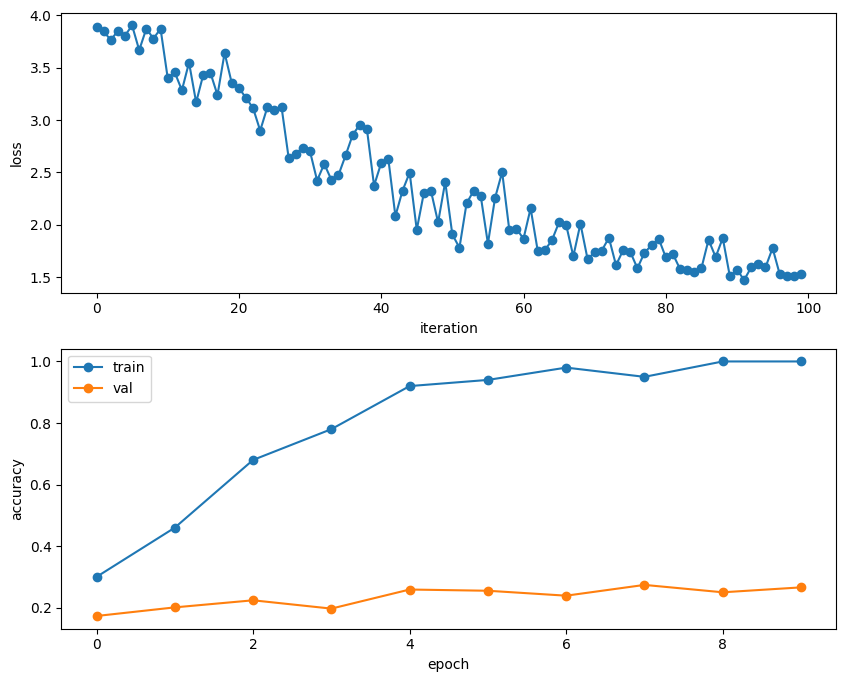

In [42]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size="3">Entraînement complet</font>

- Entraînez votre réseau pour 3 epochs.  Vous devriez avoir une justesse en validation d'**au moins ~47\%** lorsqu'entraîné sur 6,000 données.
- Par la suite, entraînez votre réseau pour 1 autre epoch mais sur **100% des données**.  Vous devriez avoir une justesse en validation d'**au moins ~57\%**.

In [43]:
from model.Solver import epoch_solver, Adam

reg = 1e-4 # à ajuster au besoin
lr = 5e-4  # à ajuster au besoin
model = create_Nlayer_cnn(reg)

optimizer = Adam(lr, model)

# change back to full X_train y_train for complete dataset
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train[:6000], 
                                                                          y_train[:6000],
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=3)

(batch 20 / 60) loss: 2.004830
(batch 40 / 60) loss: 1.817656
(batch 60 / 60) loss: 1.894336
(epoch 1 / 3) loss: 1.894336, train_acc: 0.353333, val_acc: 0.360000
(batch 20 / 60) loss: 1.799085
(batch 40 / 60) loss: 1.566833
(batch 60 / 60) loss: 1.801834
(epoch 2 / 3) loss: 1.801834, train_acc: 0.404833, val_acc: 0.413000
(batch 20 / 60) loss: 1.581112
(batch 40 / 60) loss: 1.507249
(batch 60 / 60) loss: 1.565442
(epoch 3 / 3) loss: 1.565442, train_acc: 0.495667, val_acc: 0.492000


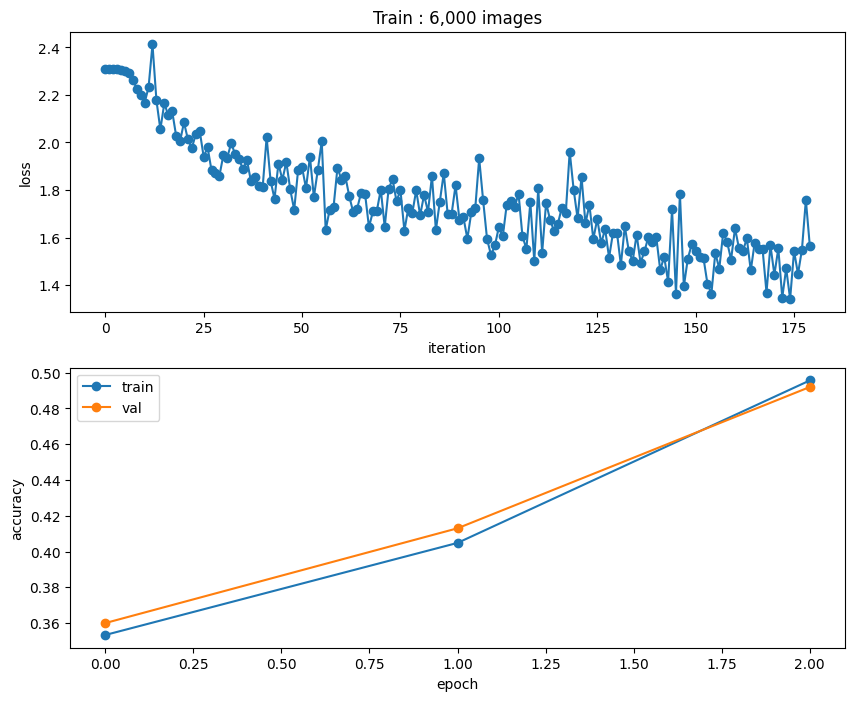

In [44]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 6,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [45]:
# On réentraîne (1 epoch) avec 100% des données d'entraînement.
loss_history, train_accuracy_history, val_accuracy_history = epoch_solver(X_train, 
                                                                          y_train,
                                                                          X_val,
                                                                          y_val,
                                                                          reg,
                                                                          optimizer,
                                                                          batch_size=100,
                                                                          epochs=1)

(batch 20 / 490) loss: 1.496975
(batch 40 / 490) loss: 1.549509
(batch 60 / 490) loss: 1.554391
(batch 80 / 490) loss: 1.388770
(batch 100 / 490) loss: 1.231690
(batch 120 / 490) loss: 1.189642
(batch 140 / 490) loss: 1.492101
(batch 160 / 490) loss: 1.425746
(batch 180 / 490) loss: 1.395400
(batch 200 / 490) loss: 1.302711
(batch 220 / 490) loss: 1.331676
(batch 240 / 490) loss: 1.373932
(batch 260 / 490) loss: 1.222343
(batch 280 / 490) loss: 0.947304
(batch 300 / 490) loss: 1.353864
(batch 320 / 490) loss: 0.974663
(batch 340 / 490) loss: 1.119472
(batch 360 / 490) loss: 1.178757
(batch 380 / 490) loss: 1.194286
(batch 400 / 490) loss: 1.110072
(batch 420 / 490) loss: 1.160054
(batch 440 / 490) loss: 1.267034
(batch 460 / 490) loss: 1.279120
(batch 480 / 490) loss: 1.014614
(epoch 1 / 1) loss: 1.119474, train_acc: 0.626939, val_acc: 0.623000


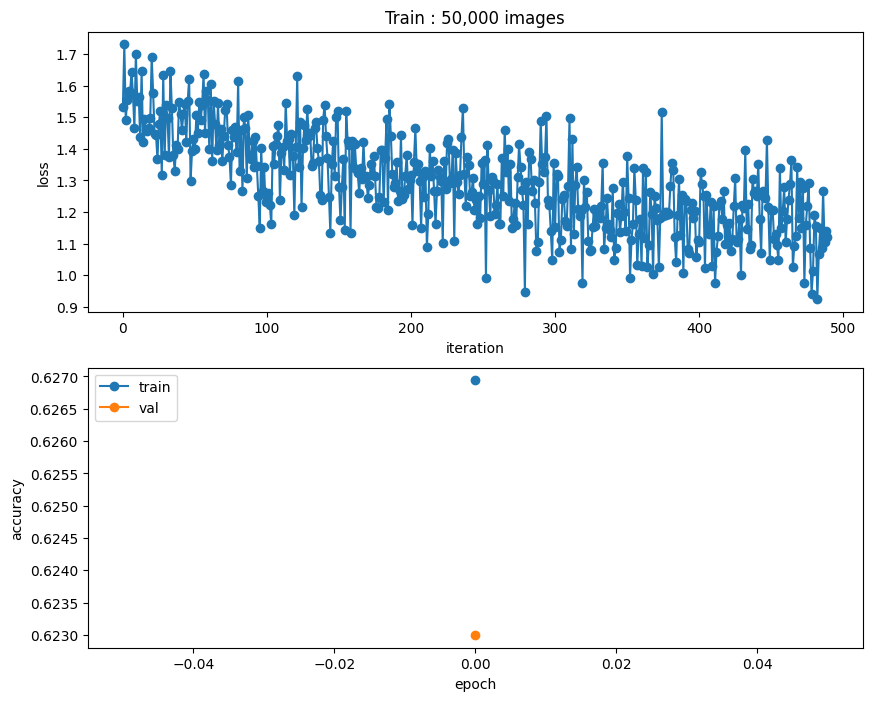

In [46]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, '-o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Train : 50,000 images')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy_history, '-o')
plt.plot(val_accuracy_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Visualisation des filtres
Vous pouvez visualiser les filtres de la première couche du réseau entraîné :

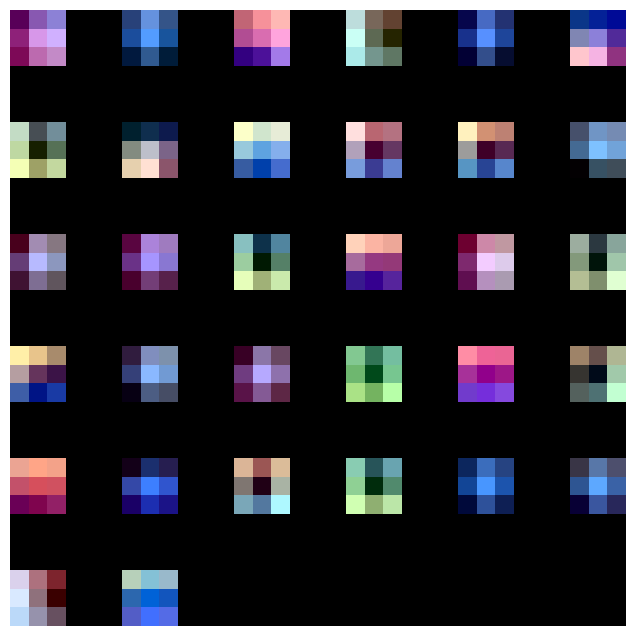

In [47]:
from visualization.utils import visualize_as_grid

def show_net_weights(model):
    W1 = model.parameters()['L0']['W']
    W1 = W1.transpose(0, 2, 3, 1)
    plt.imshow(visualize_as_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

In [48]:
print(Data_test.shape)
y_test_pred = model.predict(X_test)

test_acc = (y_test_pred == y_test).mean()
print('Test accuracy: ', test_acc)

(1000, 3, 32, 32)
Test accuracy:  0.62
